In [ ]:
import os

os.environ['TRKXINPUTDIR']="/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/out1/feature_store/"
os.environ['TRKXOUTPUTDIR']= "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/noise1"

In [2]:
import sys

sys.path.append('/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/')


# local import
from exatrkx import config_dict # for accessing predefined configuration files
from exatrkx import outdir_dict # for accessing predefined output directories
from exatrkx.src import utils_dir
from exatrkx.src import utils_robust
import matplotlib.cm as cm
from utils_robust import *

In [3]:
embed_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/embedding/checkpoints/epoch=10.ckpt'
filter_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/filtering/checkpoints/epoch=92.ckpt'
gnn_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/gnn'
ckpt_idx = -1 # which GNN checkpoint to load
dbscan_epsilon, dbscan_minsamples = 0.25, 2 # hyperparameters for DBScan
min_hits = 5 # minimum number of hits associated with a particle to define "reconstructable particles"
frac_reco_matched, frac_truth_matched = 0.5, 0.5 # parameters for track matching
noise_keep = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
evtid=1000

-----
Data(cell_data=[103305, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[103305], layerless_true_edges=[2, 123429], layers=[103305], pid=[103305], x=[103305, 3])
-----
Data(cell_data=[106831, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[106831], layerless_true_edges=[2, 389588], layers=[106831], pid=[106831], x=[106831, 3])
-----
Data(cell_data=[110358, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[110358], layerless_true_edges=[2, 1146681], layers=[110358], pid=[110358], x=[110358, 3])
-----
Data(cell_data=[113885, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[113885], layerless_true_edges=[2, 2394184], layers=[113885], pid=[113885], x=[113885, 3])
-----
Data(cell_data=[117412, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[117412], layerles

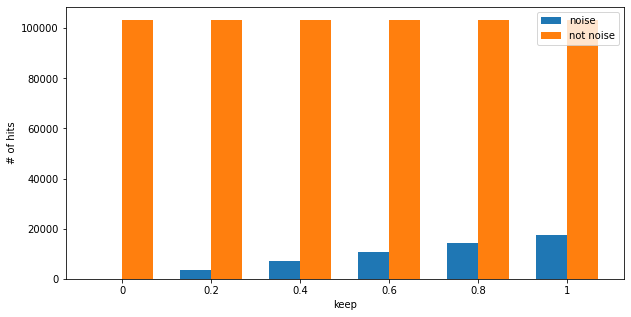

In [4]:
plot_noise_dist("/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/", noise_keep)

In [5]:
inputdir = "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/out1/feature_store/"
outputdir = "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/noise1"

0 EMBEDDING.....
0 FILTERING.....
0 BUILDING GRAPH.....
0 APPLYING GNN.....
Loaded -1 checkpoint from /global/cfs/cdirs/m3443/data/lightning_models/gnn
0 TRACK LABELLING.....


/global/homes/c/caditi97/.local/lib/python3.7/site-packages/sklearn/neighbors/_base.py:168: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


0 TRACK EFFICIENCY.....


NameError: name 'min_hits' is not defined

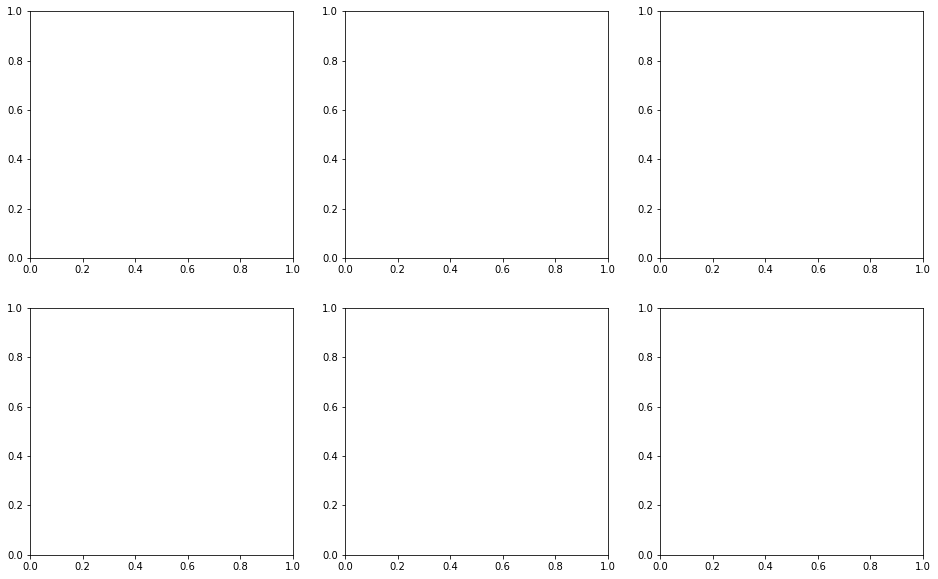

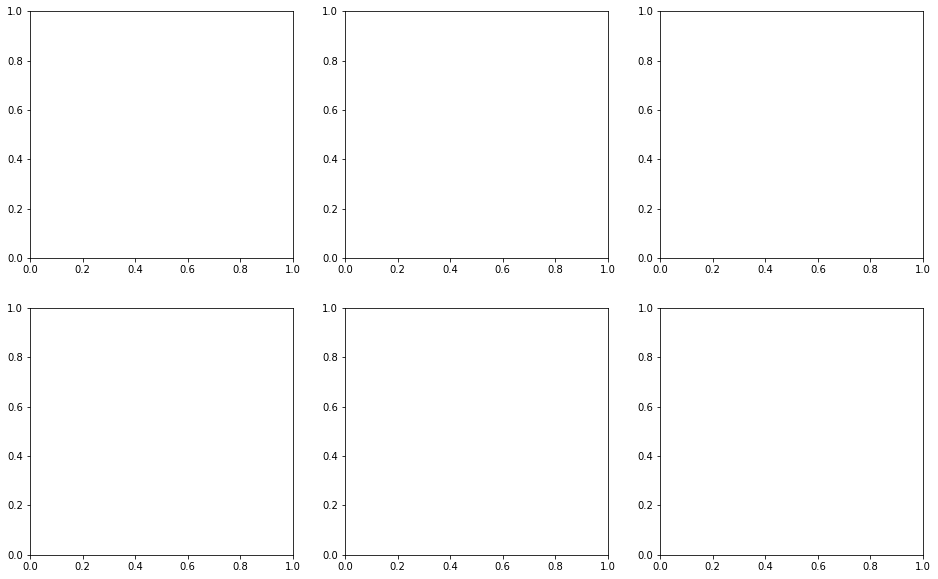

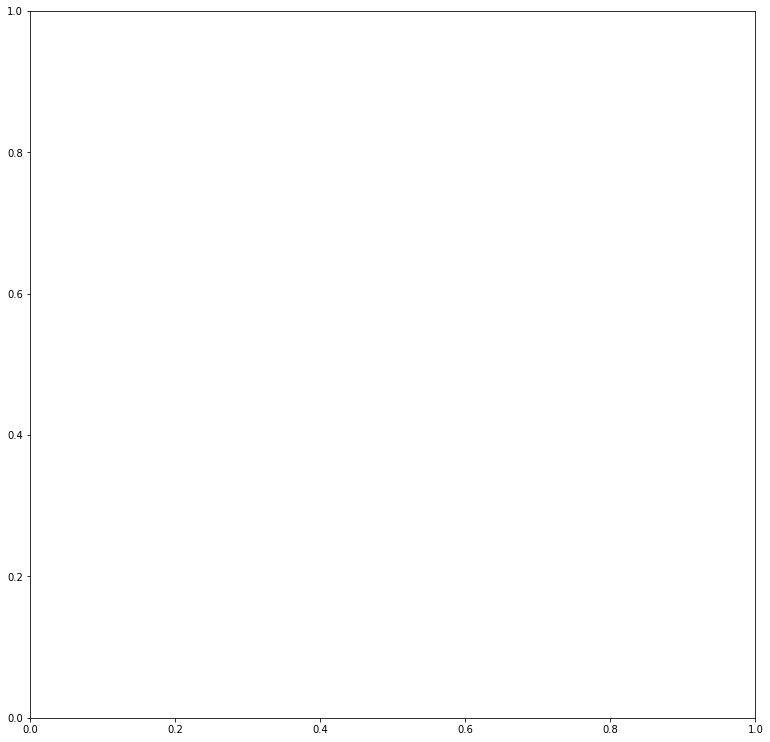

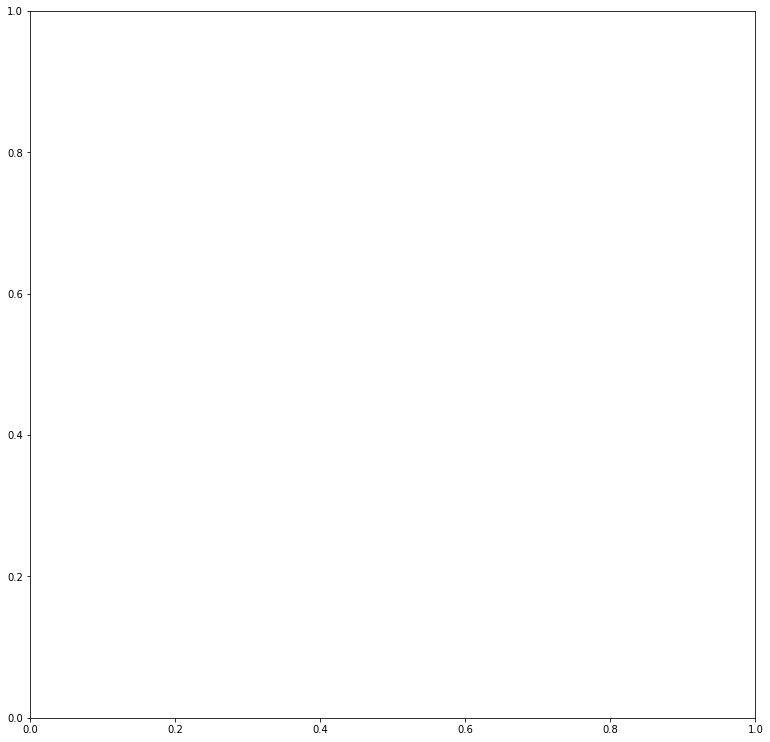

In [6]:
fig1, a1 = plt.subplots(2, 3, figsize=(16,10))
fig2, a2 = plt.subplots(2, 3, figsize=(16,10))
fig3, a3 = plt.subplots(figsize=(13,13))
fig4, a4 = plt.subplots(figsize=(13,13))
colors = cm.jet(np.linspace(0,6))

for i,n in enumerate(noise_keep):
    os.environ['TRKXINPUTDIR'] = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/out{n}/feature_store/"
    os.environ['TRKXOUTPUTDIR'] = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/noise{n}"
    output_dir = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/noise{n}"
    plots_dir = f'/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/plots/noise/{n}' # needs to change...
    evt_path = f'/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event00000{evtid}'
    data = torch.load(f'/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/out{n}/feature_store/{evtid}')
    print(f'{n} EMBEDDING.....')
    e_spatial = emb_eval(embed_ckpt_dir,data)
    print(f'{n} FILTERING.....')
    output, f_model = filtering(filter_ckpt_dir,data,e_spatial)
    print(f'{n} BUILDING GRAPH.....')
    predict_tracks = build_graph(output, f_model,data, e_spatial, gnn_ckpt_dir,output_dir,ckpt_idx,dbscan_epsilon, dbscan_minsamples,n)
    print(f'{n} TRACK EFFICIENCY.....')
    matched_idx, peta, par_pt = track_eff(evt_path, predict_tracks)
    
    print(f'{n} PLOTTING.....')
    
    plot_matched_fn = partial(plot_matched, xlegend="Matched", ylegend="Reconstructable",
                    ylabel="Events", ratio_label='Track efficiency')
    
    
    plot_matched_fn(par_pt[matched_idx], par_pt,
                 configs=pt_configs,
                 xlabel="pT [GeV]",
                 outname=os.path.join(plots_dir, "{}_pt".format(evtid)), ax1=a1[i//3][i%3],ax2=a3,c=colors[i])
    
    plot_matched_fn(peta[matched_idx], peta,
                 configs=eta_configs,
                 xlabel=r"$\eta$",
                 outname=os.path.join(plots_dir, "{}_pt".format(evtid)), ax1=a2[i//3][i%3],ax2=a4,c=colors[i])
    
